# Random Fourier Features

In [1]:
import sys
sys.path.append("../../../")

import objax
import jax
import jax.numpy as np

from jaxkern.kernels.approx import RBFSampler
from jaxkern.kernels.stationary import RBF
# from jaxkern.similarity.mmd import MMD, MMD_RBF, MMD_PXPY, MMD_PXPY_RBF
from jaxkern.kernels.sigma import estimate_sigma_median
from jaxkern.kernels.utils import centering

from jaxkern.data.similarity import generate_data

# 
import tqdm
import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

## Data

/home/emmanuel/.conda/envs/jaxkern/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


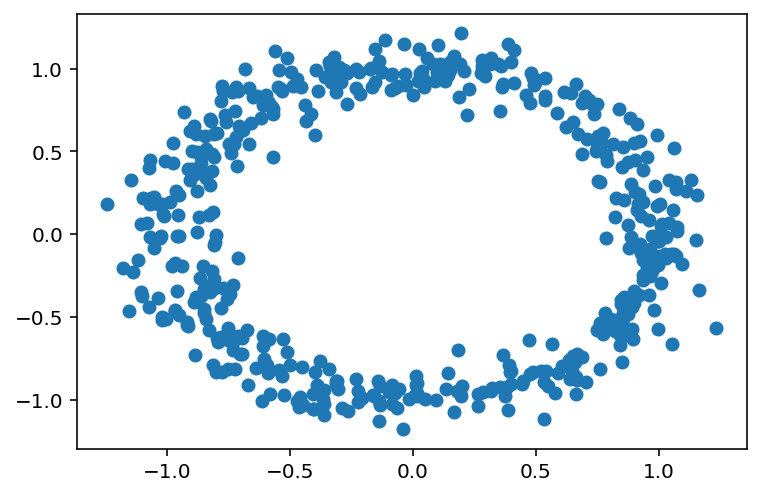

In [2]:
from scipy import stats
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
noise_y = 0.1

X, Y = generate_data(n_samples, "circle", noise_y=noise_y)

# X = stats.norm.rvs(size=(n_samples, 1))
# Y = stats.norm.rvs(size=(n_samples, 1))

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## RBF Kernel

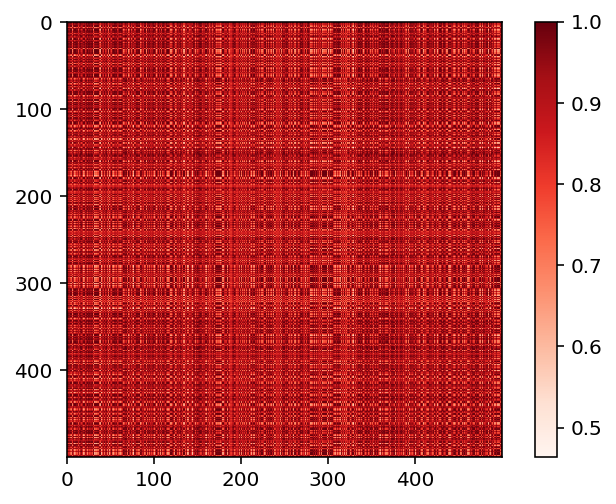

In [3]:
rbf_kernel_mat = RBF(variance=1.0, length_scale=2.0)

K_x = rbf_kernel_mat(X, X)

plt.figure()
plt.imshow(K_x, cmap='Reds')
plt.colorbar()
plt.show()

## RBF Sampler

### 1. Sample Weights

$$
\frac{1}{\sigma}\mathbf{W} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

$$
b \sim \mathcal{U}([0, 2\pi])
$$

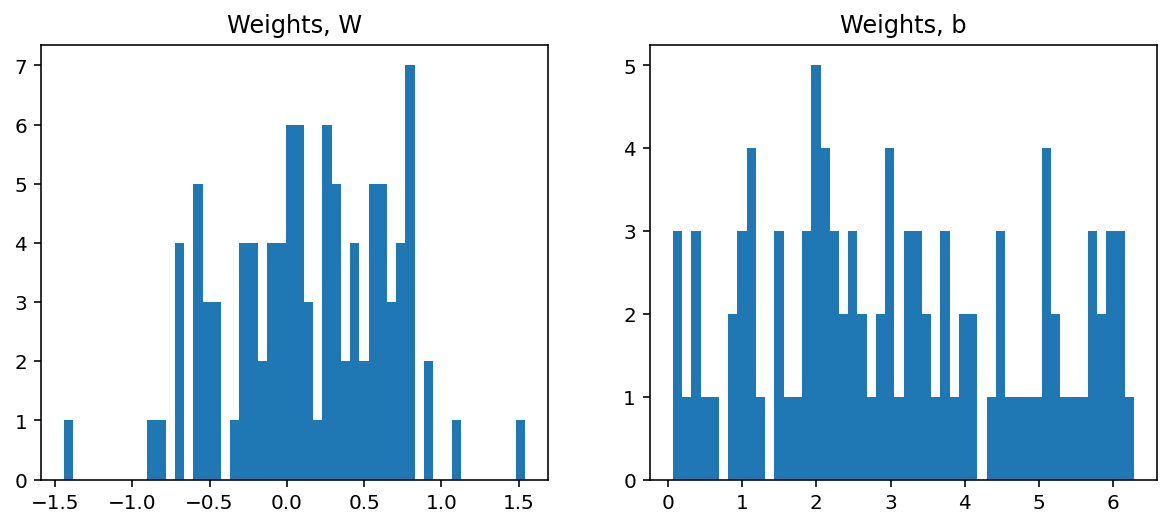

In [4]:
n_rff = 100
n_features = X.shape[1]
length_scale = 2.0


W = objax.random.normal(shape=(n_features, n_rff)) * (1 / length_scale)
b = 2 * np.pi * objax.random.uniform(shape=(n_rff,))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].hist(W.squeeze(), bins=50)
ax[0].set_title("Weights, W")
ax[1].hist(b.squeeze(), bins=50)
ax[1].set_title("Weights, b")
plt.show()

#### 3. Calculate projection matrix, Z

$$
\mathbf{Z} = \sqrt{\frac{2}{R}} \; \cos \left(\mathbf{XW} + b\right)
$$

In [5]:


Z = np.sqrt(2) / np.sqrt(n_rff) * np.cos(np.dot(X, W) + b)

W.shape, X.shape, Z.shape

((1, 100), (500, 1), (500, 100))

#### 4. Calculate Kernel Matrix $ZZ^\top$

$$
\mathbf{K} \approx \mathbf{\tilde{K}} = \mathbf{ZZ}^\top
$$

In [6]:
Kr_x = Z @ Z.T

Kr_x.shape

(500, 500)

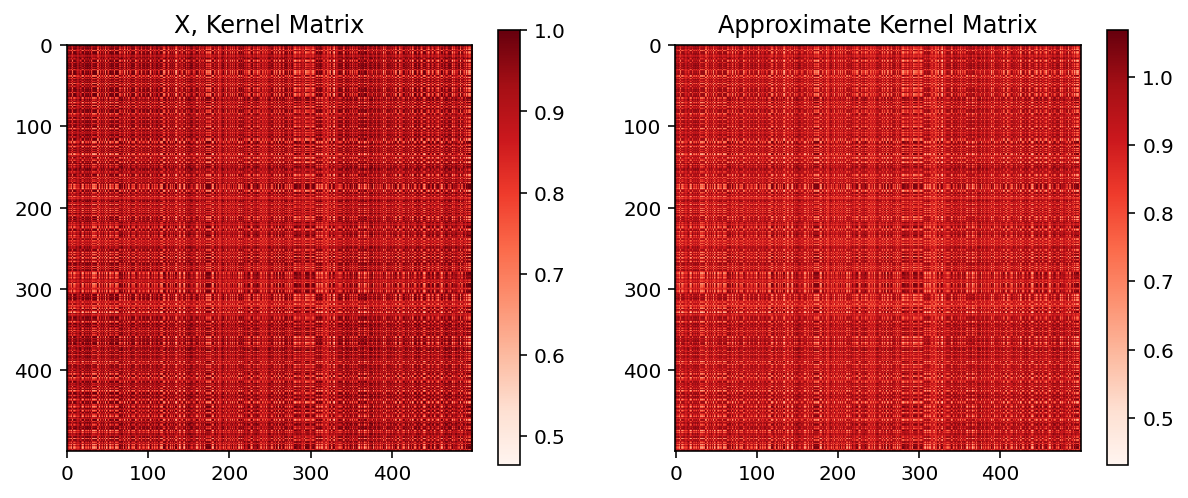

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_x, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(Kr_x, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Approximate Kernel Matrix")
plt.show()

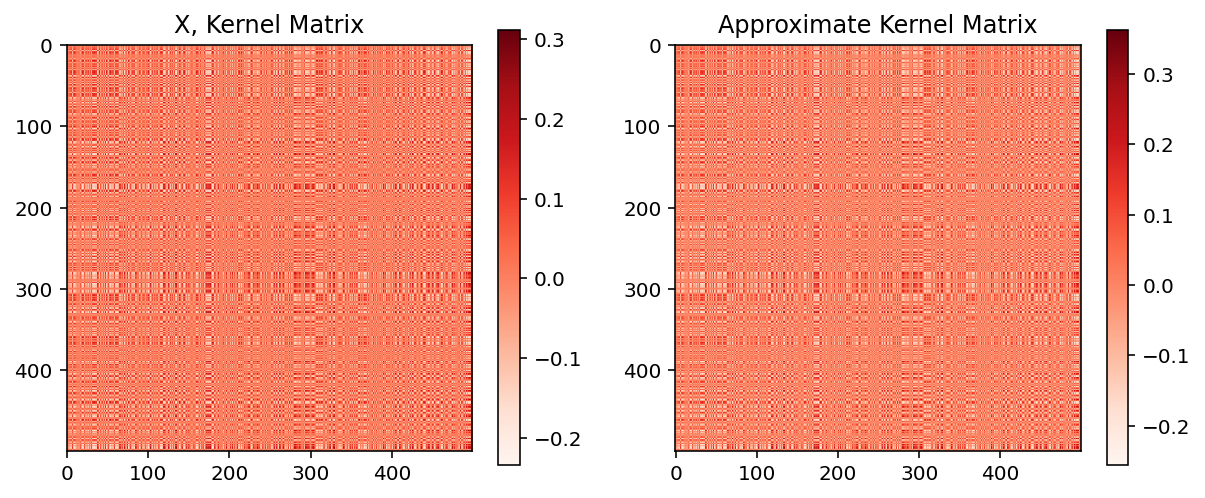

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(centering(K_x), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(centering(Kr_x), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Approximate Kernel Matrix")
plt.show()

### Convenience Function

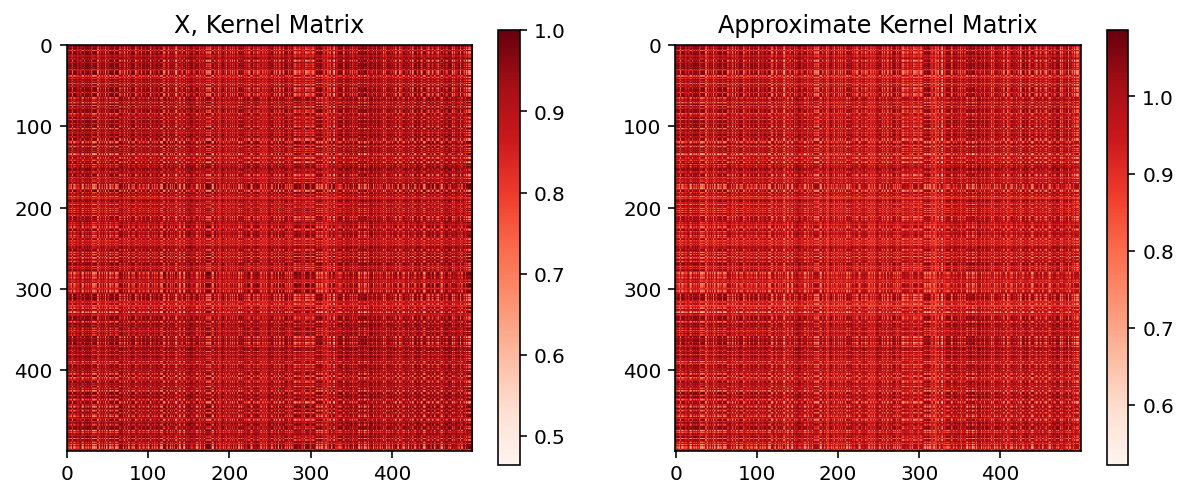

In [9]:
# real kernel matrix
K_x = RBF(length_scale=2.0, variance=1.0)(X, X)
Kr_x = RBFSampler(length_scale=2.0, n_rff=100).calculate_kernel(X)




fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_x, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(Kr_x, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Approximate Kernel Matrix")
plt.show()

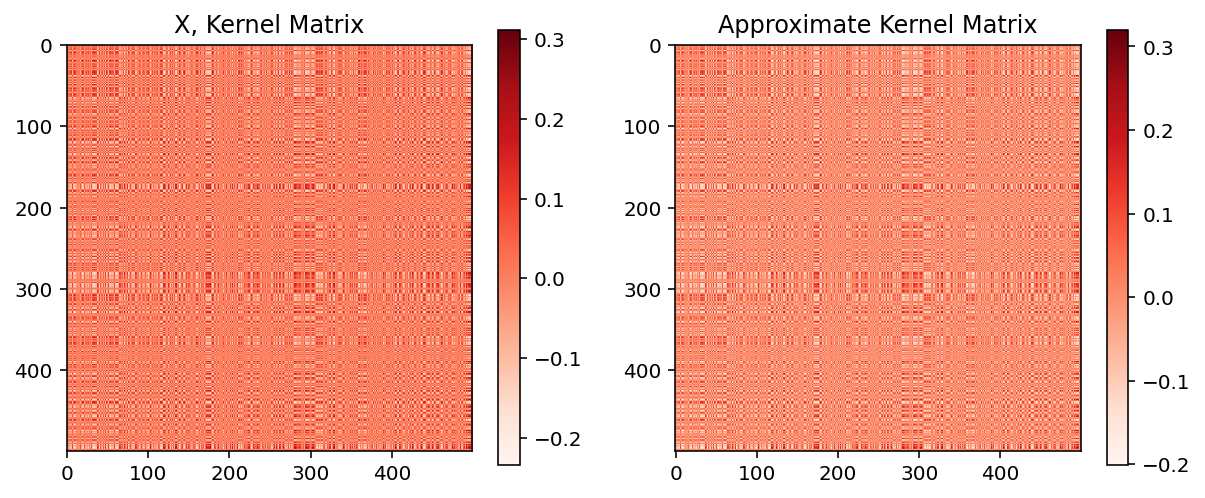

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(centering(K_x), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(centering(Kr_x), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Approximate Kernel Matrix")
plt.show()

### Approximation

In [11]:
# generate fake data
n_samples = 2_000
noise_y = 0.1

X, Y = generate_data(n_samples, "circle", noise_y=noise_y)

residuals = {
    "mae": [],
    'mse': [],
    'rmse': [],
    'norm': []
}
rffs = [1, 10, 100, 1_000, 10_000, 100_000]

for irff in tqdm.tqdm(rffs):
    K_x = RBF(length_scale=2.0, variance=1.0)(X, X)
    Kr_x = RBFSampler(length_scale=2.0, n_rff=irff).calculate_kernel(X)
    
    # calculate metrics
    residuals['mae'].append(np.abs(K_x - Kr_x).mean())
    residuals['mse'].append(np.power(K_x - Kr_x, 2).mean())
    residuals['rmse'].append(np.sqrt(np.power(K_x - Kr_x, 2).mean()))
    residuals['norm'].append(np.linalg.norm(K_x - Kr_x))

100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


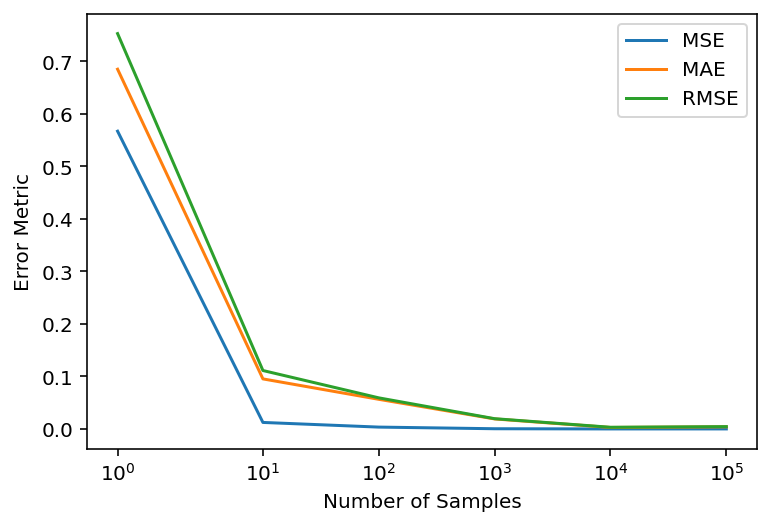

In [12]:
plt.figure()
plt.plot(rffs, residuals['mse'], label="MSE")
plt.plot(rffs, residuals['mae'], label="MAE")
plt.plot(rffs, residuals['rmse'], label="RMSE")
plt.xscale('symlog')
plt.xlabel("Number of Samples")
plt.ylabel("Error Metric")
plt.legend()
plt.show()

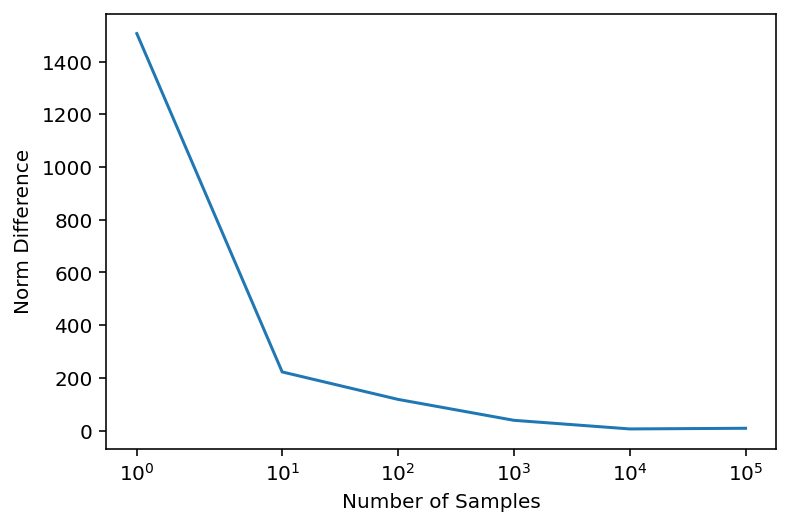

In [13]:
plt.plot(rffs, residuals['norm'], label="Norm")
plt.xscale('symlog')
plt.xlabel("Number of Samples")
plt.ylabel("Norm Difference")
plt.show()